In [8]:
import numpy as np
import torch

In [16]:
import torch
import kornia.geometry.transform as kornia_transform

class ShiftImage:
    def __init__(self, max_shift_x=50, max_shift_y=50):
        self.max_shift_x = max_shift_x
        self.max_shift_y = max_shift_y

    def __call__(self, tensor: torch.Tensor, shift: tuple = None) -> torch.Tensor:
        # If no shift is provided, raise an error
        if shift is None:
            raise ValueError("Shift values must be explicitly provided.")

        shift_x, shift_y = shift
        translation = torch.tensor([[shift_x, shift_y]], dtype=torch.double)

        return kornia_transform.translate(
            tensor.unsqueeze(0).double(),
            translation,
            mode="bilinear",
            padding_mode="border",
            align_corners=True,
        ).squeeze(0).float()

class RotateImage:
    def __init__(self, center=None, mode='bilinear', padding_mode='border', align_corners=True):
        self.center = center
        self.mode = mode
        self.padding_mode = padding_mode
        self.align_corners = align_corners

    def __call__(self, img, angle):
        # Ensure the input is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input must be a tensor")
        
        # # Add a batch dimension if needed (Kornia expects a batch of tensors)
        # if img.ndim == 3:  # [C, H, W]
        #     img = img.unsqueeze(0)  # Add batch dimension [B, C, H, W]
        
        return kornia_transform.rotate(
            img, angle, self.center, self.mode, self.padding_mode, self.align_corners
        )

In [17]:
pre_op = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_pre_label_0.npz")["data"]
post_op = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_post_label_0.npz")["data"]
feature_map_pre = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/third_conv_0.npz")['third_conv_0']
feature_map_post = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/third_conv_0_post.npz")['third_conv_1']
shift_values = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/third_conv_0.npz")['shift_values']
change_map = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_change_map_label_0.npz")['data']
pre_tumor = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_pre_tumor_label_0.npz")['data']
post_tumor = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_post_tumor_label_0.npz")['data']
feature_map_pre = torch.tensor(feature_map_pre)
feature_map_post = torch.tensor(feature_map_post)
pre_op = torch.tensor(pre_op)
change_map = torch.tensor(change_map)
shift_tensor = ShiftImage()
rotate_Image = RotateImage()

(-0.5, 255.5, 255.5, -0.5)

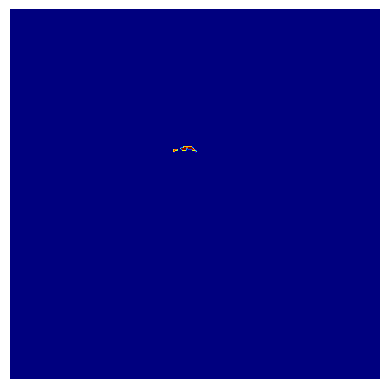

In [18]:
import matplotlib.pyplot as plt

# Get the indices of non-zero values
non_zero_indices = torch.nonzero(change_map, as_tuple=True)

# Calculate the number of values to keep (10% of non-zero values)
num_to_keep = int(len(non_zero_indices[0]) * 0.03)

# Get the indices of the bottom 10% non-zero values
sorted_indices = torch.argsort(non_zero_indices[0])
indices_to_keep = sorted_indices[:num_to_keep]

# Create a mask to zero out 90% of the non-zero values
mask = torch.zeros_like(change_map, dtype=torch.bool)
mask[non_zero_indices[0][indices_to_keep], non_zero_indices[1][indices_to_keep]] = True

# Apply the mask to the change_map
change_map *= mask.float()

plt.imshow(change_map.numpy(), cmap='jet')
plt.axis('off')


In [ ]:
import cv2
from numpy import ndarray
import numpy as np

def normalize_np_array(array: ndarray) -> ndarray:
    if np.max(array) == np.min(array):
        return array
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def multiplicative_sharpening(distance_map: np.ndarray, base_image: np.ndarray, alpha=12.0, beta=1):
    """Apply multiplicative sharpening by injecting high-frequency details from the base image."""
    assert distance_map.max() <= 1.0, f"max: {distance_map.max()}"
    assert distance_map.min() >= 0.0, f"min: {distance_map.min()}"
    assert base_image.max() <= 1.0, f"max: {base_image.max()}"
    assert base_image.min() >= 0.0, f"min: {base_image.min()}"

    # Blur the base image and calculate high-frequency details
    blurred_image = cv2.GaussianBlur(base_image, (5, 5), 0)
    high_freq_details = base_image - blurred_image

    # Compute sharpened map for high-value regions
    sharpened_map = distance_map * (1 + alpha * high_freq_details)
    
    # Add contribution from the base image in low-value regions
    enhanced_map = sharpened_map + beta * base_image * (1 - distance_map)

    # Normalize the final result to keep it within [0, 1]
    enhanced_map = normalize_np_array(enhanced_map)
    
    return enhanced_map

def multiplicative_sharpening1(distance_map: np.ndarray, base_image: np.ndarray, alpha=1.0):
    """Apply multiplicative sharpening by injecting high-frequency details from the base image."""
    # Compute high-frequency details
    blurred_image = cv2.GaussianBlur(base_image, (5, 5), 0)  # You can tune the kernel size
    high_freq_details = base_image - blurred_image
    
    # Multiply the distance map with the high-frequency details
    sharpened_map = distance_map * (1 + alpha * high_freq_details)
    
    # Normalize the sharpened map to ensure it stays within [0, 1]
    sharpened_map = normalize_np_array(sharpened_map)
    
    return sharpened_map

def multiplicative_sharpening_and_filter(distance_map: np.ndarray, base_image: np.ndarray, alpha=9.0, threshold=0.15):
    """Apply multiplicative sharpening by injecting high-frequency details from the base image."""
    assert distance_map.max() <= 1.0, f"max: {distance_map.max()}"
    assert distance_map.min() >= 0.0, f"min: {distance_map.min()}"
    assert base_image.max() <= 1.0, f"max: {base_image.max()}"
    assert base_image.min() >= 0.0, f"min: {base_image.min()}"

    # Create a binary mask where base image values are above the threshold
    mask = (base_image > threshold).astype(np.float32)
    
    # Blur the base image and calculate high-frequency details
    blurred_image = cv2.GaussianBlur(base_image, (5, 5), 0)
    high_freq_details = base_image - blurred_image

    # Compute sharpened map for high-value regions
    sharpened_map = distance_map * (1 + alpha * high_freq_details)

    # Apply the mask to filter the distance map
    enhanced_map = mask * sharpened_map + (1 - mask) * base_image

    # Normalize the final result to keep it within [0, 1]
    enhanced_map = normalize_np_array(enhanced_map)
    
    return enhanced_map


In [47]:
enhanced =  multiplicative_sharpening(np.rot90(change_map.detach().numpy()),
                                      np.rot90(pre_op.detach().numpy()))
enhanced_2 =  multiplicative_sharpening_and_filter(np.rot90(change_map.detach().numpy()),
                                        np.rot90(pre_op.detach().numpy()), alpha=5)

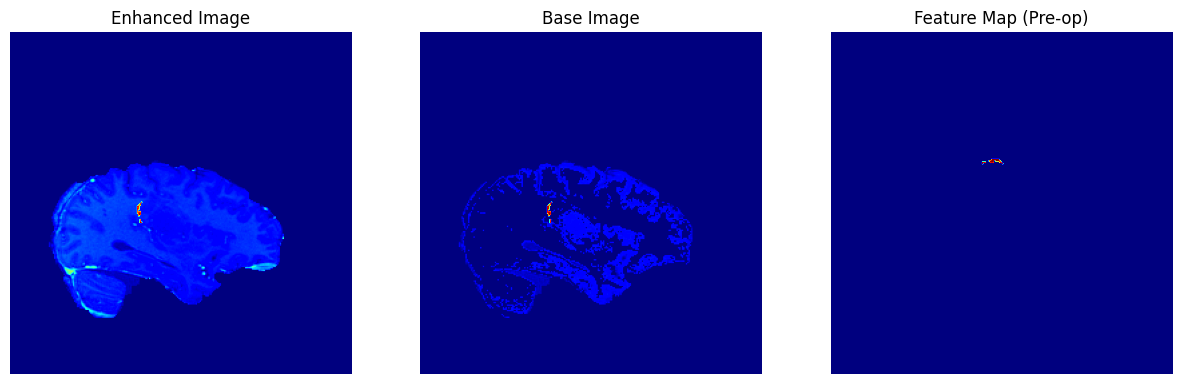

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the enhanced image
axs[0].imshow(enhanced, cmap='jet')
axs[0].set_title('Enhanced Image')
axs[0].axis('off')

# Plot the base image in grayscale
axs[1].imshow(enhanced_2, cmap='jet')
axs[1].set_title('Base Image')
axs[1].axis('off')

# Plot the feature map
axs[2].imshow(change_map.detach().numpy(), cmap='jet')
axs[2].set_title('Feature Map (Pre-op)')
axs[2].axis('off')

plt.show()

In [51]:
def multiplicative_sharpening_and_filter(distance_map: np.ndarray, base_image: np.ndarray, alpha=1.0, beta=1, threshold=0.8, max_intensity=0.6, overlay_weight=0.5):
    """Apply sharpening while ensuring the base image remains grayscale and distance map is visualized using JET colormap."""
    assert distance_map.max() <= 1.0, f"max: {distance_map.max()}"
    assert distance_map.min() >= 0.0, f"min: {distance_map.min()}"
    assert base_image.max() <= 1.0, f"max: {base_image.max()}"
    assert base_image.min() >= 0.0, f"min: {base_image.min()}"

    # Normalize the base image to be clearly visible in grayscale
    base_image = custom_np_norm(base_image, min_val=0.2, max_val=0.8)

    # Thresholding the distance map
    distance_map = (distance_map > threshold).astype(np.float32) * distance_map  # Keep only values above threshold

    # Extract high-frequency details from the base image
    blurred_image = cv2.GaussianBlur(base_image, (5, 5), 0)
    high_freq_details = base_image - blurred_image

    # Sharpening based purely on the distance map's strength
    sharpened_map = distance_map * (1 + alpha * high_freq_details)

    # Ensure low base image regions still retain enhancement
    enhanced_map = sharpened_map + beta * (1 - distance_map) * base_image

    # Normalize enhanced map
    enhanced_map = custom_np_norm(enhanced_map, min_val=0.0, max_val=max_intensity)

    # Convert base image to 3-channel grayscale for visualization
    base_gray = cv2.cvtColor((base_image * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Convert enhanced map to JET colormap
    distance_colormap = cv2.applyColorMap((enhanced_map * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Blend grayscale base image with the distance colormap
    final_visualization = cv2.addWeighted(base_gray, (1 - overlay_weight), distance_colormap, overlay_weight, 0)

    return final_visualization